In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

from world import World
from utils import plotarrows, getpolicy, getvalue

plt.rcParams['figure.facecolor']='white'

In [2]:
which_world = 1 #Change later. Valid options: [1-4]

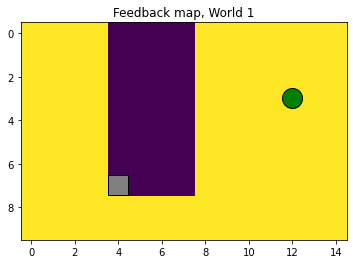

In [3]:
# Initialization
# Initialize the world, Q-table, and hyperparameters

# Init world and draw
world = World(which_world)
world.draw()

# Init Q-table
x_size = world.x_size # 15
y_size = world.y_size # 10
n_actions = 4 # up, down, left ,right

# Initialize q_table as small random negative numbers
q_table = (-1/10)*np.ones((y_size, x_size, n_actions)) 
with np.nditer(q_table, op_flags=['readwrite']) as it:
    for x in it:
        x[...] -= np.random.random() / 10
        
# Set actions in terminal node to 100 according to hints in compendium.
#q_table[world.term[0], world.term[1]] = 100

    # Init hyperparams
if which_world == 1:
    lr = 0.95 # Since world is static we can have a large learning rate
    discount = 0.5 # Recommended start at 0.9: Lower -> short term, higher -> long term. Here we want longterm
    epsilon = 0.1 # Higher epsilon focus on exploration
    n_episodes = 1000
elif which_world == 2:
    # Since this world changes to sometimes we make the algorithm retain more information from previous states
    lr = 0.1     # Therefore we decrease the learning rate to keep more information from previous q-values.
    discount = 0.6 # Recommended start at 0.9
    epsilon = 0.9 # Higher epsilon focus on exploration
    n_episodes = 2000 
elif which_world == 3:
    lr = 0.9
    discount = 0.3 # Here we decrease the discount so that the algorithm focuses more on short term goals instead of long term
    epsilon = 0.9 # Higher epsilon focus on exploration
    n_episodes = 2000 
elif which_world == 4:
    lr = 0.15
    discount = 0.6 # Here we decrease the discount so that the algorithm focuses more on short term goals instead of long term -> this way we perhaps avoid the negative area.
    epsilon = 0.9 # Higher epsilon focus on exploration, lower on exploitation
    n_episodes = 50000 #1000 # Number of iterations
    

In [4]:
#print(f"Starting position: {world.pos}")
#print(f"Feed map matrix: {world.feed}")
#print(f"Goal position. {world.term}")
print(f"Max reward: {np.max(world.feed)}")
#print(f"Q-TABLE: {q_table}")
#q_table[world.pos[0], world.pos[1]]

Max reward: -0.1


In [5]:
####### The training loop #######
max_reward = np.max(world.feed)
for episode in range(n_episodes):
    
    if episode != 0: # If not first episode -> init a new world
        world = World(which_world)

    if episode % 1000 == 0:
        print(episode)
        
    # Find current position at start of new episode
    current_location = world.pos
    
    while world.pos != world.term: # While not in a terminal state do
        
        previous_location = world.pos
        
        # Decide which action to take by greedy exploitation
        if np.random.random() < epsilon:
            action = np.random.randint(4) + 1 # Generate integer between 1 and 4
        else:
            action = np.argmax(q_table[world.pos[0],world.pos[1]]) + 1
        # Take the action
        action_data = world.action(action)
        
        # Draw the world
        #world.draw(episode = episode, sleepTime = 0)
        
        # Get new location
        current_location = world.pos
        ### Get the reward for moving to the new location
            
        if action_data[0] == 0:
            reward = -np.inf # If invalid action then negative reward
            if which_world == 4:
                reward = -1
        else:
            reward = action_data[1] # If action is valid then actual reward
            
        if world.pos == world.term:
            reward = 1# Big reward if hit terminal
        
       # Update Q-table
        q_table[previous_location[0], previous_location[1], action-1] = (1-lr)*q_table[previous_location[0], previous_location[1], action-1] + lr*(reward + discount*getvalue(q_table[current_location[0], current_location[1]]))
    
    if episode > n_episodes * 0.75:
        epsilon = 1/3
        

0


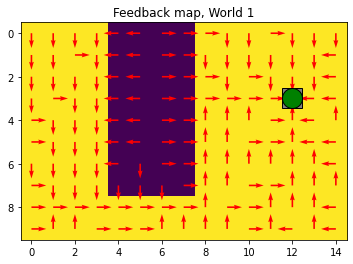

In [6]:
# Test loop
# Test the agent (subjectively) by letting it use the optimal policy to traverse the gridworld.
# Do not update the Q-table when testing.
# Also, you should not explore when testing, i.e. epsilon=0; always pick the optimal action.

#epsilon = 0

# Initialize a test world
world = World(which_world)
# Retrieve the optimal policy
pol = getpolicy(q_table)
##### Test loop #####
while world.pos != world.term: # While not in a terminal state do
    current_location = world.pos # Get current position position
    action = np.argmax(q_table[world.pos[0],world.pos[1]]) + 1
    # Take the action
    action_data = world.action(action)
    world.draw(policy = pol)    

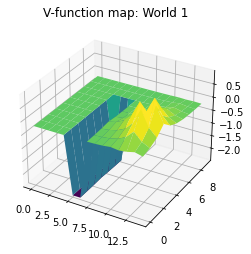

In [7]:
def plotVfun(Q):
    V = np.max(Q, axis = 2)
    x = np.arange(0, V.shape[1], 1)
    y = np.arange(0, V.shape[0], 1)
    x, y = np.meshgrid(x,y)
    z = V
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z,cmap = 'viridis', edgecolor='none')
    ax.set_title(f"V-function map: World {which_world}")
    plt.show()

plotVfun(q_table)

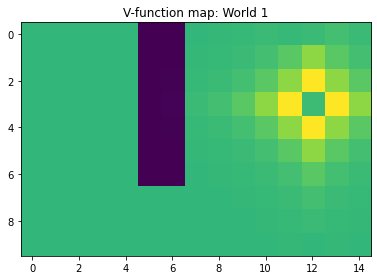

In [8]:
def plotVfun2(Q, World_num):
    V = np.max(Q, axis = 2)
    fig, ax = plt.subplots()
    im = ax.imshow(V)
    ax.set_title(f"V-function map: World {which_world}")
    fig.tight_layout()
    plt.show()
    
plotVfun2(q_table, 1) 

In [8]:
print(np.max(q_table, axis = 2))

[[-1.99991047e-01 -1.99982095e-01 -1.99964190e-01 -1.99928379e-01
  -1.99964190e-01 -2.41998209e+00 -1.83328125e+00  9.73437500e-01
   2.14687500e+00  4.49375000e+00  9.18750000e+00  1.85750000e+01
   3.73500000e+01  1.85750000e+01  9.18750000e+00]
 [-1.99982095e-01 -1.99964190e-01 -1.99928379e-01 -1.99856758e-01
  -1.99928379e-01 -2.41996419e+00 -1.24656250e+00  2.14687500e+00
   4.49375000e+00  9.18750000e+00  1.85750000e+01  3.73500000e+01
   7.49000000e+01  3.73500000e+01  1.85750000e+01]
 [-1.99964190e-01 -1.99928379e-01 -1.99856758e-01 -1.99713516e-01
  -1.99856758e-01 -2.35656250e+00 -7.31250000e-02  4.49375000e+00
   9.18750000e+00  1.85750000e+01  3.73500000e+01  7.49000000e+01
   1.50000000e+02  7.49000000e+01  3.73500000e+01]
 [-1.99928379e-01 -1.99856758e-01 -1.99713516e-01 -1.99427032e-01
  -1.99713516e-01 -1.18312500e+00  2.27375000e+00  9.18750000e+00
   1.85750000e+01  3.73500000e+01  7.49000000e+01  1.50000000e+02
   1.00000000e+02  1.50000000e+02  7.49000000e+01]
 [-1